### NYC - London flights analysis
*July 2019*

<br>

**Author - Jelena Lor**

*Dataset was scraped by myself from Expedia*

For the code to scrap the dataset please see: <br>
https://github.com/jelenalor/scrap_FlightInfo


<br>

Data was scraped on Monday 15/07/2019 (Working day) in NYC <br>
Prices are in US dollars and time is Eastern Daylight Time <br>
All the prices are for return flights departing a week from scrap day and return a week from departure <br>

<br>

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
%matplotlib inline

In [2]:
data = pd.read_csv(r"dataset16072019.csv")
data.head(2)

,current_date,current_time,departure_time,arrival_time,airline,duration,stops,price,dep_airport,arr_airport,operated_by,other
0,2019-7-15,17:49,7:00pm,7:10am,Norwegian Air UK,6h 55m,(Nonstop),"$1,006",Liberty Intl. (EWR),Heathrow (LHR),United 14,Boeing 767-300 | Dinner
1,2019-7-15,17:49,11:25am,11:20pm,Norwegian Air UK,7h 0m,(Nonstop),"$1,051",John F. Kennedy Intl. (JFK),Gatwick (LGW),Norwegian Air UK 7914 operated by Evelop Airlines,Airbus A330-300 | Food and beverage for purchase


### Data Cleaning

In [3]:
# Separate 'other' column
data["plane"] = [x.split("|")[0] for x in data["other"]]
data["extra"] = [x.split("|")[1] if (len(x.split("|")) == 2) else "NA" for x in data["other"]]

#Convert times and dates to datetime
# 1) Make date month in the zero padded format - for datetime format
data["current_date"] = [x.split("-")[0]+"-0"+x.split("-")[1]+"-"+x.split("-")[2] for x in data["current_date"]]
data["scrap_datetime"] = pd.to_datetime(data["current_date"] + "-" + data["current_time"], format='%Y-%m-%d-%H:%M', errors='ignore')

data["arrival_datetime"] = pd.to_datetime(data["arrival_time"], format='%I:%M%p').dt.strftime('%H:%M:%S')
data["departure_datetime"] = pd.to_datetime(data["departure_time"], format='%I:%M%p').dt.strftime('%H:%M:%S')

# Conver flight departure into 2 buckets -> Morning flight, and Night flights (any flight arriving in the morning) 
def createFlightType(row):
    # if arrival time is before 11 in the morning - night flight
    if row < '12:00:00' and row > '02:00:00':
        return "night"
    else:
        return "day"
data["flight_type"] = data["arrival_datetime"].apply(lambda x: createFlightType(x))

#Create duration in minutes
def durationToMinutes(row):
    hours = int("".join(list(row.split()[0])[:-1]))
    minutes = int("".join(list(row.split()[1])[:-1]))
    duration_in_minutes = int(hours * 60 + minutes)
    return duration_in_minutes

data["duration_minutes"] = data["duration"].apply(lambda x: durationToMinutes(x))

# Extract the hour the price was scrapped
data["scrap_hour"] = [x.hour for x in data["scrap_datetime"]]

# Operated by - clean
data["operated_airline"] = [x.split()[0] for x in data["operated_by"]]

# Price to int
data["price"] = [int("".join(x[1:].split(","))) for x in data["price"] ]

# Drop stops - the datasets only includes nonstop flights
# Drop other columns
data.drop(["stops", "other", "departure_time", "arrival_time", "current_date", "current_time", "operated_by", "duration"], axis =1, inplace = True)

# Solve string inconsistencies in plane names
data["plane"][data["plane"] == "Airbus A330-300 "] = "Airbus A330-300"
data["plane"][data["plane"] == "Airbus A330-200 "] = "Airbus A330-200"
data["plane"][data["plane"] == "Boeing 777 "] = "Boeing 777"
data["plane"][data["plane"] == "Boeing 777-200 "] = "Boeing 777-200"
data["plane"][data["plane"] == "Boeing 747-400 "] = "Boeing 747-400"
data["plane"][data["plane"] == "Airbus A340-600 "] = "Airbus A340-600"
data["plane"][data["plane"] == "Boeing 767-300 "] = "Boeing 767-300"
data["plane"][data["plane"] == "Boeing 787-8 "] = "Boeing 787-8"

C:\Users\kabachok\Anaconda2\envs\lion\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kabachok\Anaconda2\envs\lion\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kabachok\Anaconda2\envs\lion\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kabachok\Anaconda2\envs\lion\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A val

In [4]:
# Duplicate flights
# Consider duplicate if - departure time - departure airport and operated by airline are the same (sometimes the airlines can be 
# different but correspond to the same flight - operated by)
original_flights = data.drop_duplicates(subset = ["departure_datetime", "dep_airport", "operated_airline"], keep = "first")

# Create a column to identify unique flightd
data["unique_flight"] = data["operated_airline"] + "-" + data["dep_airport"] + "-" + data["departure_datetime"]

In [5]:
# Clean dataset
data.head(2)

,airline,price,dep_airport,arr_airport,plane,extra,scrap_datetime,arrival_datetime,departure_datetime,flight_type,duration_minutes,scrap_hour,operated_airline,unique_flight
0,Norwegian Air UK,1006,Liberty Intl. (EWR),Heathrow (LHR),Boeing 767-300,Dinner,2019-07-15 17:49:00,07:10:00,19:00:00,night,415,17,United,United-Liberty Intl. (EWR)-19:00:00
1,Norwegian Air UK,1051,John F. Kennedy Intl. (JFK),Gatwick (LGW),Airbus A330-300,Food and beverage for purchase,2019-07-15 17:49:00,23:20:00,11:25:00,day,420,17,Norwegian,Norwegian-John F. Kennedy Intl. (JFK)-11:25:00


## Exploratory Data Analysis

In [6]:
# I like to choose my own colors for visualisaion -> set up color palette
# Good color source - > https://www.webucator.com/blog/2015/03/python-color-constants-module/
my_colors = {"red": "#EE3B3B", "blue": "#7AC5CD", "lightgreen": "#A2CD5A", "darkgreen": "#458B74", "brown": "#CD9B1D"}

In [7]:
print("There are approximately %s flights from NYC to London daily" %original_flights.shape[0])

There are approximately 84 flights from NYC to London daily


### Questions  - general overview


1) Which airline provides the most number of flights per day? <br>
2) What is the most popular plane? <br>
3) What time of day are the most flights? <br>
4) What is the most popular departure and arrival airports? <br>
<br>

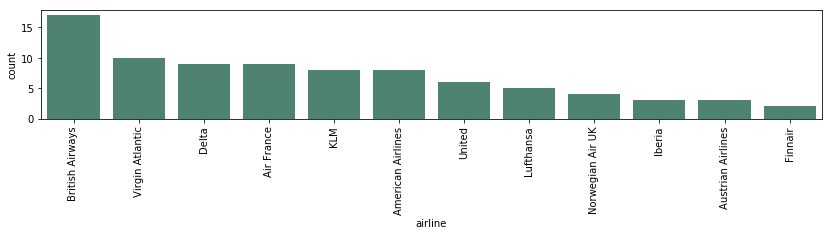

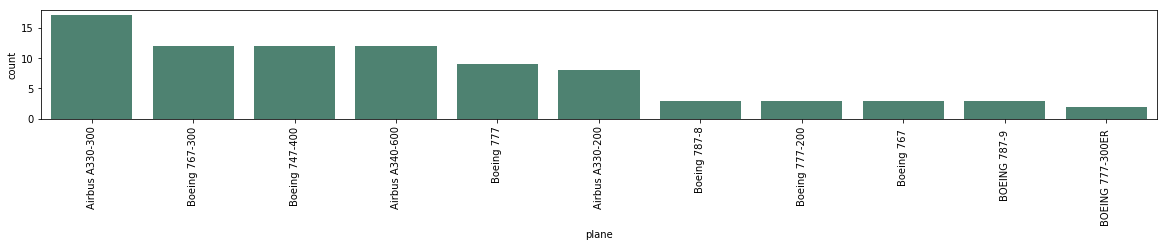

In [8]:
plt.figure(figsize = (14, 2))
v, c = np.unique(original_flights["airline"], return_counts=True)
sns.countplot(data = original_flights, x = "airline", color = my_colors["darkgreen"], order = v[np.argsort(c)[::-1]] )
plt.xticks(rotation = 90)
plt.show()

plt.figure(figsize = (20, 2))
v, c = np.unique(original_flights["plane"], return_counts=True)
sns.countplot(data = original_flights, x = "plane", color = my_colors["darkgreen"], order = v[np.argsort(c)[::-1]] )
plt.xticks(rotation = 90)
plt.show()


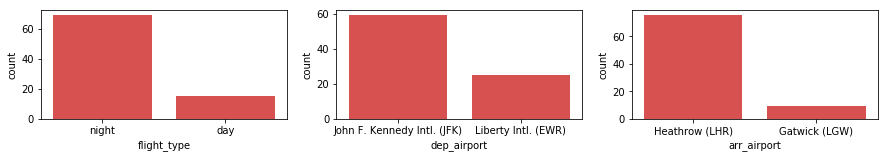

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 2))
v, c = np.unique(original_flights["flight_type"], return_counts=True)
sns.countplot(data = original_flights, x = "flight_type", color = my_colors["red"], order = v[np.argsort(c)[::-1]], ax = ax[0] )

v, c = np.unique(original_flights["dep_airport"], return_counts=True)
sns.countplot(data = original_flights, x = "dep_airport", color = my_colors["red"], order = v[np.argsort(c)[::-1]], ax = ax[1] )

v, c = np.unique(original_flights["arr_airport"], return_counts=True)
sns.countplot(data = original_flights, x = "arr_airport", color = my_colors["red"], order = v[np.argsort(c)[::-1]], ax = ax[2] )

plt.show()

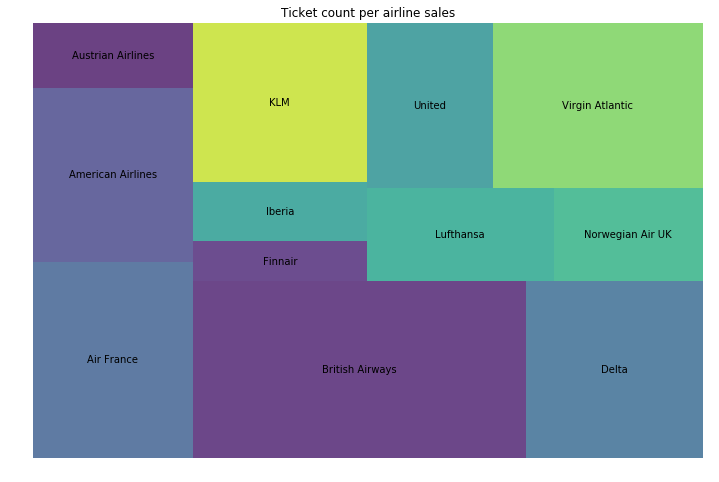

In [19]:
plt.figure(figsize = (12, 8))
squarify.plot(sizes = original_flights.groupby("airline").count()["price"].values, label = original_flights.groupby("airline").count()["price"].index, alpha=.8 )
plt.axis('off')
plt.title("Ticket count per airline sales")
plt.show() 

# BA sells the most tickets

### Comments

BA has the most flights per day, followed by Virgin airlines <br>
Boeing 767-300 and Airbus A330-300 are the most popular planes <br>
Most flights are during the night <br>
JFK and Heathrow most popular airports <br>

<br>

### Questions - detailed overview


1) For which airline what is the most popular plane? <br>
2) Which airport each airline fly to from? <br>
3) Distribution of flights by time of day by airline <br>
4) What is the most popular departure and arrival airports? <br>
<br>

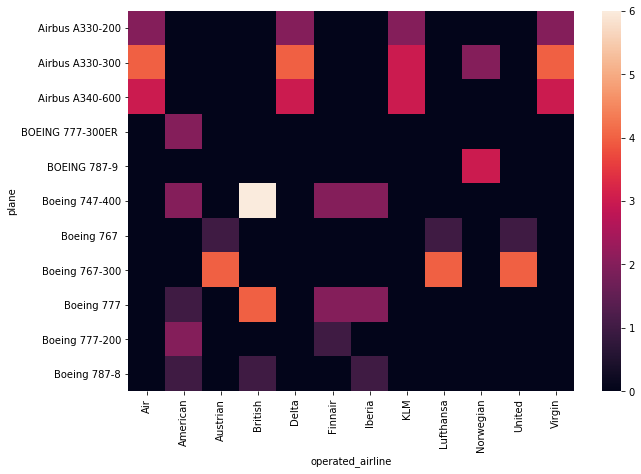

In [173]:
plane_airline_gp = original_flights.groupby(["plane", "operated_airline"]).count()["airline"].reset_index()
plt.figure(figsize = (10, 7))
sns.heatmap(pd.pivot_table(data = plane_airline_gp, index = "plane",\
                           columns = "operated_airline", values = "airline", aggfunc=np.sum, fill_value=0))
plt.show()

### Comments

1) Delta, KLM, Air, Virgin - use only Airbus <br>
2) All the rest (except Norwegian) use only Boeing <br>
3) Norwegian has only two types of planes flying NYC - London (Boeing 787-9 and Airbus A330-300)


<br>


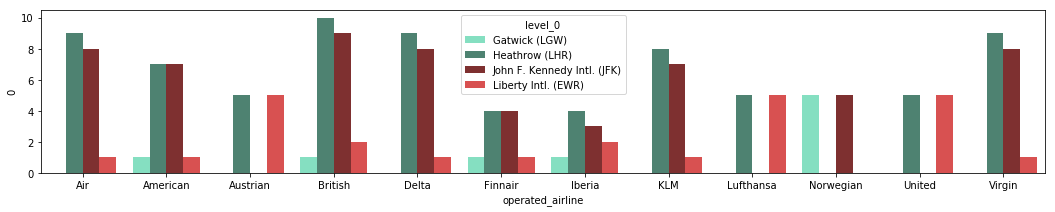

In [174]:
# Data preparation
airport_airline_arrival = pd.pivot_table(data = original_flights, index = "operated_airline", \
                                         columns = "arr_airport", values = "price", aggfunc = 'count', fill_value=0)
airport_airline_departure = pd.pivot_table(data = original_flights, index = "operated_airline", \
                                         columns = "dep_airport", values = "price", aggfunc = 'count', fill_value=0)
airport_airline = pd.concat([airport_airline_arrival, airport_airline_departure], axis = 1)
airport_airline_un = airport_airline.unstack().reset_index()

# Data Visualisation
plt.figure(figsize = (18, 3))
colors = {"Gatwick (LGW)": "#76EEC6", "Heathrow (LHR)": "#458B74", "Liberty Intl. (EWR)": "#EE3B3B", "John F. Kennedy Intl. (JFK)": "#8B2323"}
sns.barplot(data = airport_airline_un, x = "operated_airline", y =0, hue = "level_0", palette=colors)
plt.show()

### Comments

1) Most popular departure airport: JFK <br>
2) Most popular arrival airport in London: Heathrow <br>
3) Lufthansa, Austrian and United travels from EWR to Heathrow, which is unusual route <br>
4) Norwegian travels JFK to Gatwick <br>
5) The rest of airlines mostly travel JFK to Heathrow


<br>


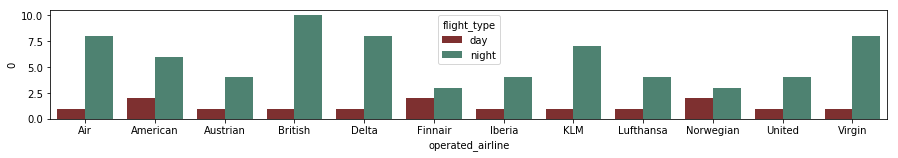

In [175]:
# Data preparation
airline_tod = pd.pivot_table(data = original_flights, index = "operated_airline", \
                                         columns = "flight_type", values = "price", aggfunc = 'count', fill_value=0)
airline_tod_un = airline_tod.unstack().reset_index()

# Data Visualisation
plt.figure(figsize = (15, 2))
colors = {"night": "#458B74", "day": "#8B2323"}
sns.barplot(data = airline_tod_un, x = "operated_airline", y =0, hue = "flight_type", palette=colors)
plt.show()

### Comments

1) Night flights are the most popular <br>
2) Most airlines have significantly more night flights compared to day flights <br>
3) Norwegian and Finnair has more day flights in proportion to their total flights to London <br>

<br>

<br>


### Questions - Flight duration

1) Duration by airline <br>
2) Duration by time <br>
3) Duration by dep airport/ arr airport <br>

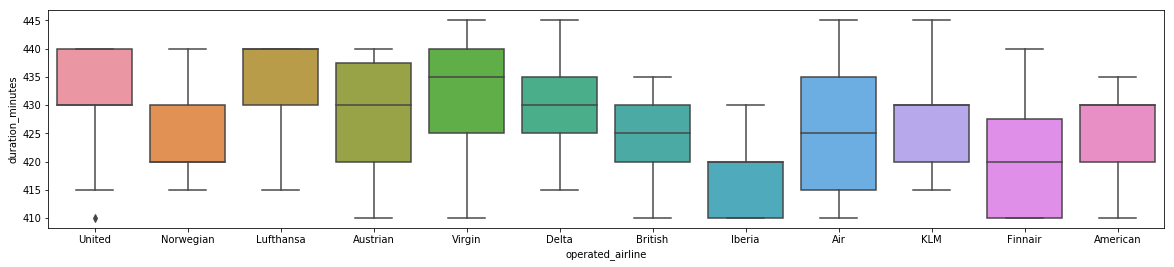

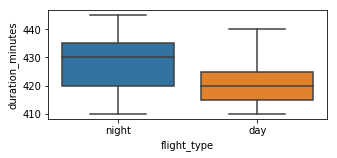

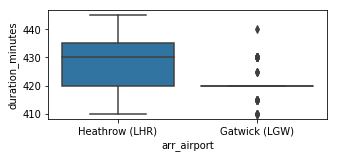

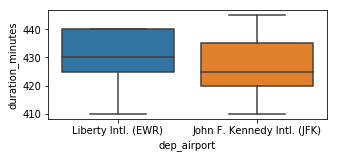

In [177]:
plt.figure(figsize = (20, 4))
sns.boxplot(data = data, x = "operated_airline", y = "duration_minutes")
plt.show()

plt.figure(figsize = (5, 2))
sns.boxplot(data = data, x = "flight_type", y = "duration_minutes")
plt.show()

plt.figure(figsize = (5, 2))
sns.boxplot(data = data, x = "arr_airport", y = "duration_minutes")
plt.show()

plt.figure(figsize = (5, 2))
sns.boxplot(data = data, x = "dep_airport", y = "duration_minutes")
plt.show()

### Comments

1) Most flights duration is around 430 minutes (7 hours and 10 minutes) <br>
2) Average duration for day flights is 10 minutes less than night flights <br>
*This is likely caused due to the high number of night flights departing at similar time <br>
and causing traffic on arrival or departure* <br>

3) The same is true for flights departing from JFK <br>
4) This is true because majority of day flights are departing from JFK <br>


<br>

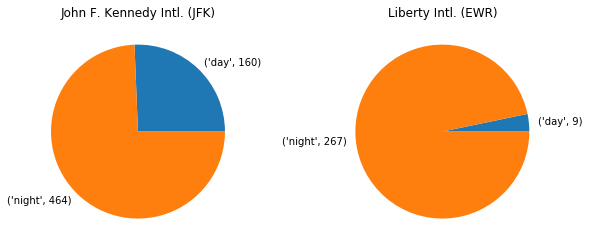

In [216]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

jfk = data.groupby(["dep_airport", \
              "flight_type"]).count()["airline"].reset_index()[data.groupby(["dep_airport", \
                                                                             "flight_type"]).count()["airline"].reset_index()["dep_airport"] ==\
                                                               "John F. Kennedy Intl. (JFK)" ][["flight_type", "airline"]]
frac, labels = jfk["airline"], jfk["flight_type"]
ax[0].pie(frac, labels = [x for x in zip(labels, frac)])
ax[0].set_title("John F. Kennedy Intl. (JFK)")


jfk = data.groupby(["dep_airport", \
              "flight_type"]).count()["airline"].reset_index()[data.groupby(["dep_airport", \
                                                                             "flight_type"]).count()["airline"].reset_index()["dep_airport"] ==\
                                                               "Liberty Intl. (EWR)" ][["flight_type", "airline"]]
frac, labels = jfk["airline"], jfk["flight_type"]
ax[1].pie(frac, labels = [x for x in zip(labels, frac)])
ax[1].set_title("Liberty Intl. (EWR)")

plt.show()

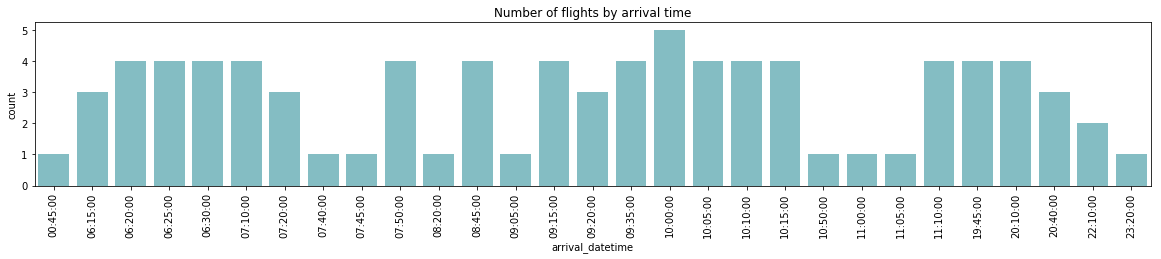

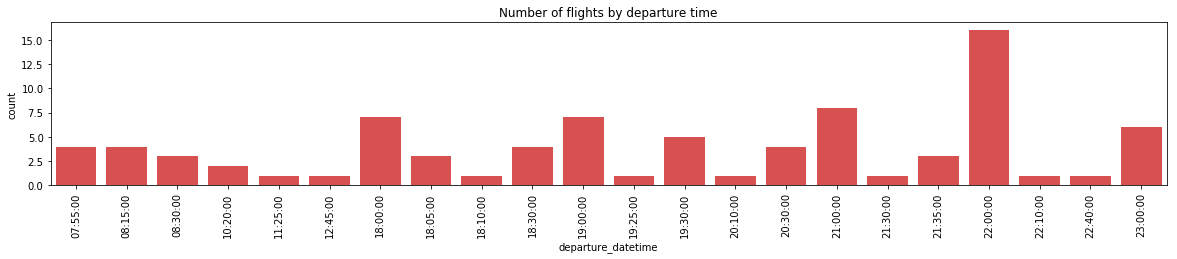

In [15]:
plt.figure(figsize = (20, 3))
sns.countplot(data = original_flights, x = "arrival_datetime", color = my_colors["blue"], order = np.sort(data["arrival_datetime"].unique()))
plt.xticks(rotation = 90)
plt.title("Number of flights by arrival time")
plt.show()


plt.figure(figsize = (20, 3))
sns.countplot(data = original_flights, x = "departure_datetime", color = my_colors["red"], order = np.sort(data["departure_datetime"].unique()))
plt.xticks(rotation = 90)
plt.title("Number of flights by departure time")
plt.show()

### Comments

1) 10 pm is the most popular departure time with 15 flights <br>
2) The flights are arriving throughout the morning in London between 6am and around 11 am

<br>

### Questions - Flight prices


1) Price by airline <br>
2) Price timeseries (by airline, type of flight, time, departure airport, arrival airport <br>
3) Operated by vs Advertised by - difference in price? <br>
4) Price by plane type <br>
5) Price by flight_type <br>
6) Number of prices for the same flights <br>
 
<br>

In [16]:
print("Maximum price recorded is %s and minimum is %s " %(data["price"].max(), data["price"].min()))

Maximum price recorded is 5515 and minimum is 892 


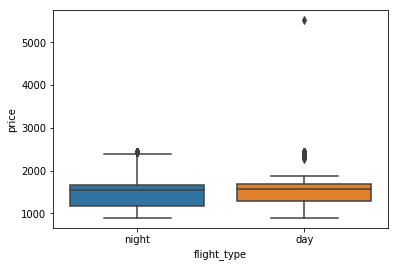

In [17]:
plt.figure(figsize = (6, 4))
sns.boxplot(data = data, x = "flight_type", y = "price")
plt.show()

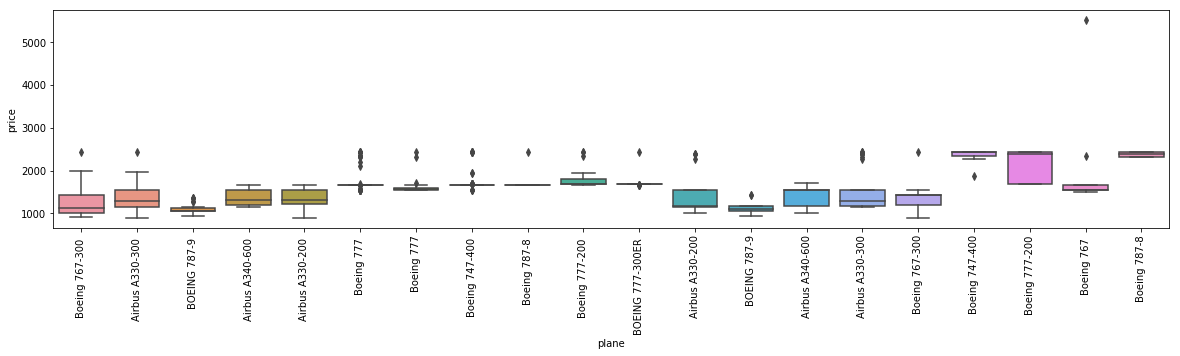

In [18]:
plt.figure(figsize = (20, 4))
sns.boxplot(data = data, x = "plane", y = "price")
plt.xticks(rotation = 90)
plt.show()

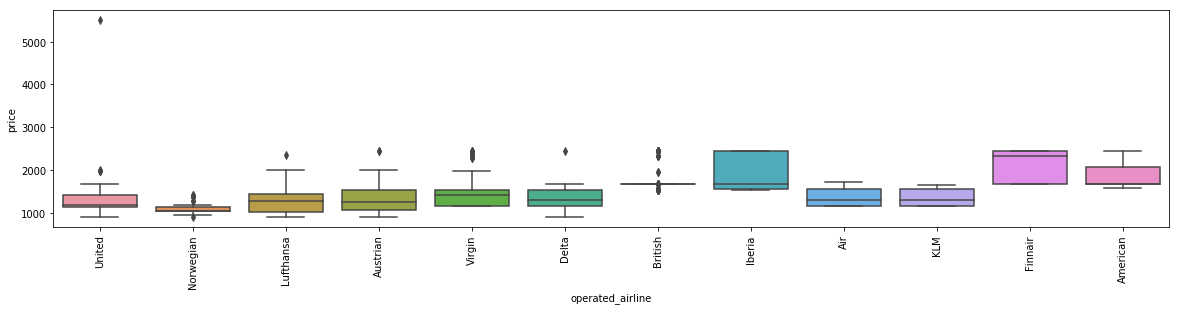

In [19]:
plt.figure(figsize = (20, 4))
sns.boxplot(data = data, x = "operated_airline", y = "price")
plt.xticks(rotation = 90)
plt.show()

### Comments

1) Day flight price is slightly higher on average compared to night flight price <br>
2) Overall prices are similar by most of the operated airlines, which is just over \$1,000 <br>
3) Norwegian offers the lowest fares <br>
4) Virgin, Iberia, Finnair are on the higher side <br>

United has one flight with price over \$5,000 which is very likely for a first class ticket <br>
and therefore is not comparable to the rest of the prices

<br>

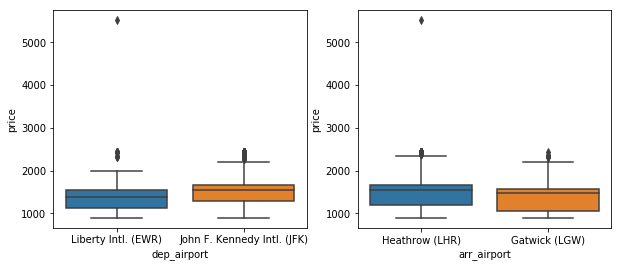

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

sns.boxplot(data = data, x = "dep_airport", y = "price", ax= ax[0])
sns.boxplot(data = data, x = "arr_airport", y = "price", ax= ax[1])

plt.show()

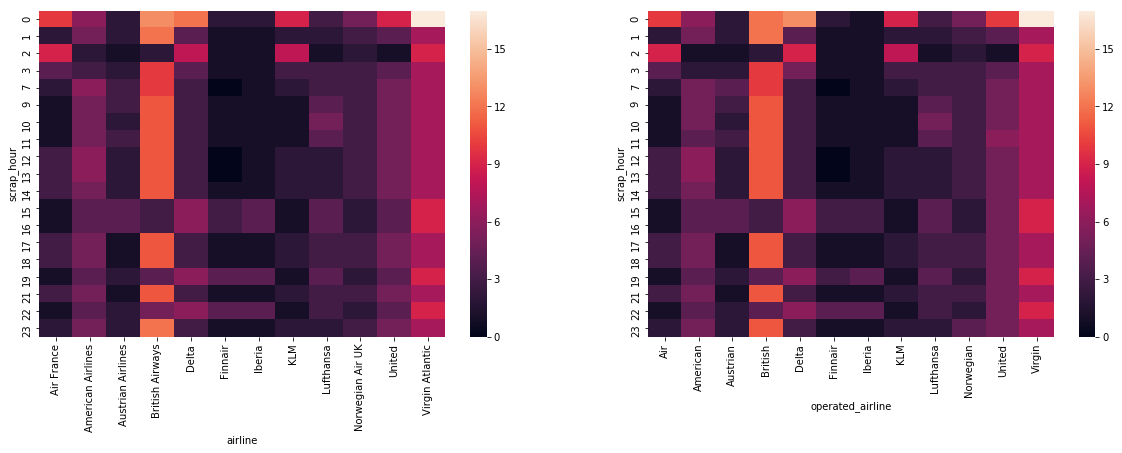

In [217]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))

sns.heatmap(pd.pivot_table(data = data, index = "scrap_hour", columns = "airline", values = "price", aggfunc = 'count', fill_value=0), ax = ax[0])
sns.heatmap(pd.pivot_table(data = data, index = "scrap_hour", columns = "operated_airline", values = "price", aggfunc = 'count', fill_value=0), ax = ax[1])

plt.show()

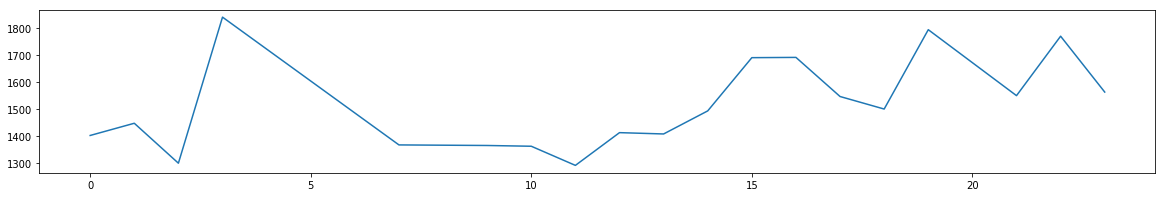

In [21]:
plt.figure(figsize = (20, 3))
plt.plot(data.groupby("scrap_hour").mean()["price"].index, data.groupby("scrap_hour").mean()["price"].values)
plt.show()


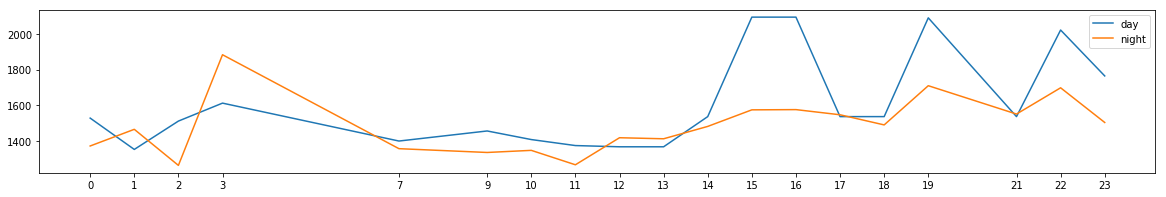

In [45]:
plt.figure(figsize = (20, 3))

plt.plot(data[data["flight_type"] == "day"].groupby("scrap_hour").mean()["price"].index,\
         data[data["flight_type"] == "day"].groupby("scrap_hour").mean()["price"].values, label = "day")

plt.plot(data[data["flight_type"] == "night"].groupby("scrap_hour").mean()["price"].index,\
         data[data["flight_type"] == "night"].groupby("scrap_hour").mean()["price"].values, label = "night")

plt.xticks(data[data["flight_type"] == "night"].groupby("scrap_hour").mean()["price"].index, \
           data[data["flight_type"] == "night"].groupby("scrap_hour").mean()["price"].index)
plt.legend()
plt.show()

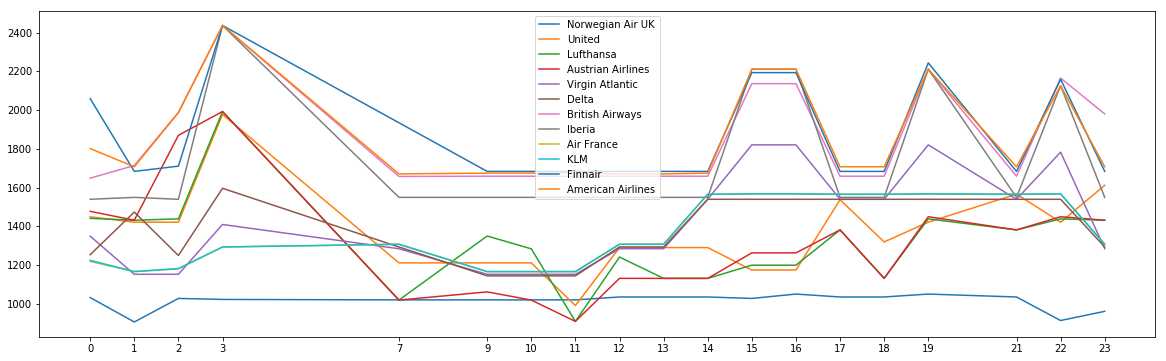

In [47]:
plt.figure(figsize = (20, 6))

for i in data["airline"].unique():
    plt.plot(data[data["airline"] == i].groupby("scrap_hour").mean()["price"].index,\
             data[data["airline"] == i].groupby("scrap_hour").mean()["price"].values, label = i)


plt.xticks(data[data["flight_type"] == "night"].groupby("scrap_hour").mean()["price"].index, \
           data[data["flight_type"] == "night"].groupby("scrap_hour").mean()["price"].index)
plt.legend()
plt.show()

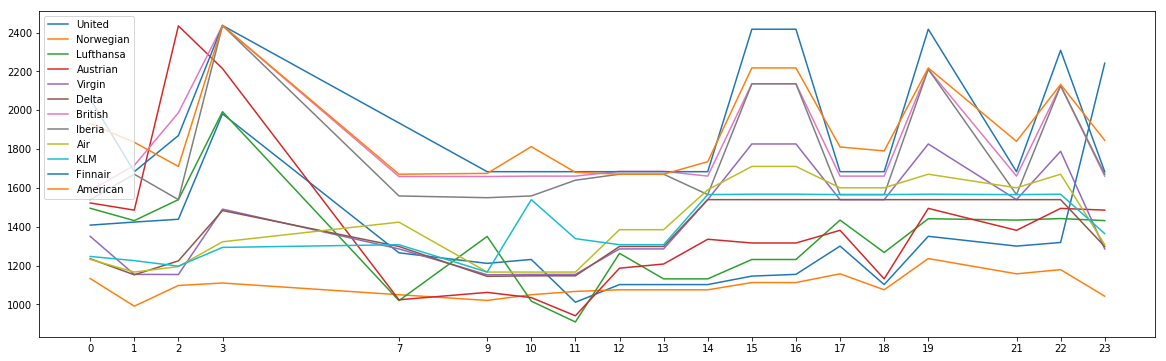

In [48]:
plt.figure(figsize = (20, 6))

for i in data["operated_airline"].unique():
    plt.plot(data[data["operated_airline"] == i].groupby("scrap_hour").mean()["price"].index,\
             data[data["operated_airline"] == i].groupby("scrap_hour").mean()["price"].values, label = i)


plt.xticks(data[data["flight_type"] == "night"].groupby("scrap_hour").mean()["price"].index, \
           data[data["flight_type"] == "night"].groupby("scrap_hour").mean()["price"].index)
plt.legend()
plt.show()

### Comments

1) Average price seem to be higher early in the morning (3 am) <br>
2) The lowest average price is at between 7 am - 11 am <br>
3) The prices for day flights go up just after 2pm <br>
4) Prices for flights operated by Norwegian airlines do not fluctuate much during the day <br>

<br>

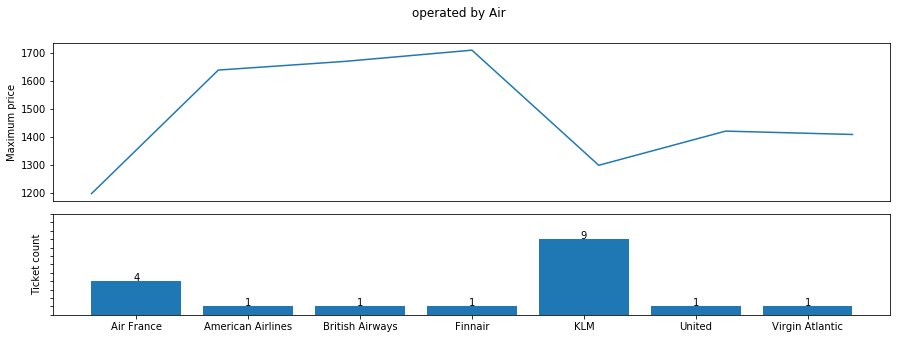

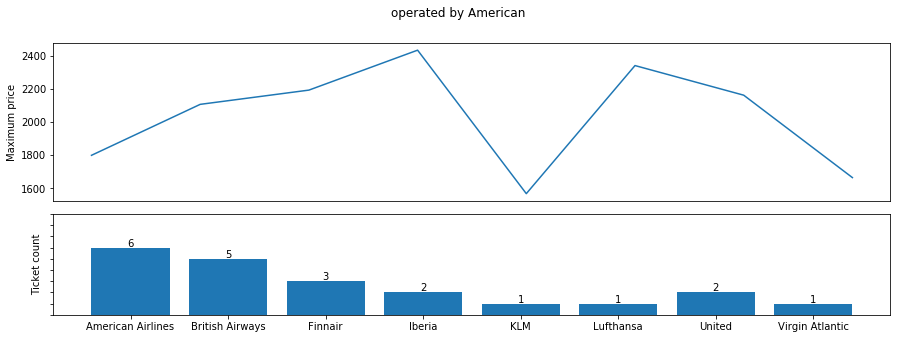

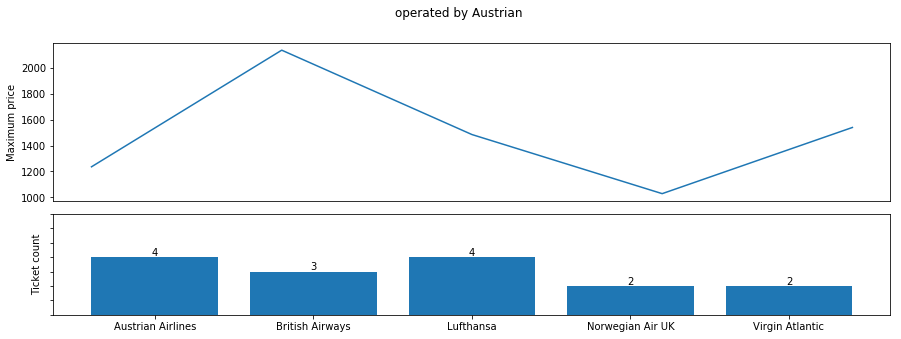

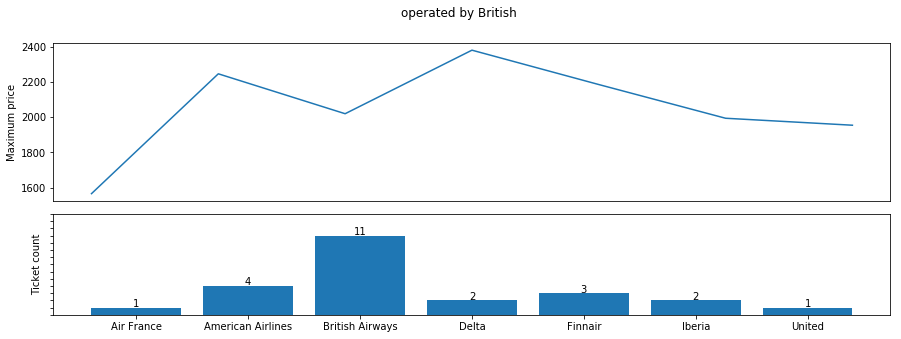

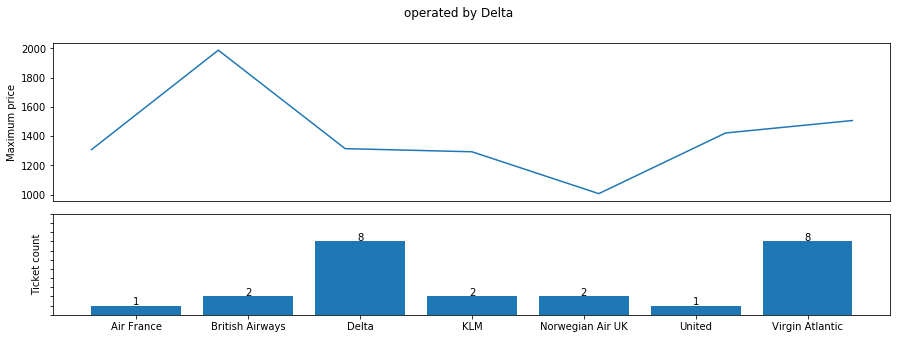

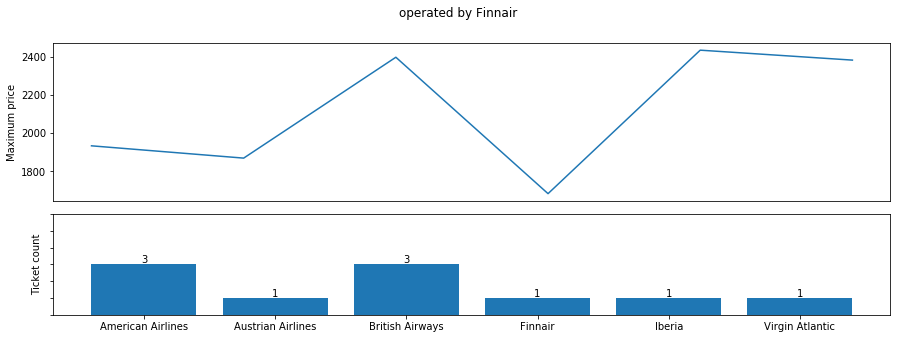

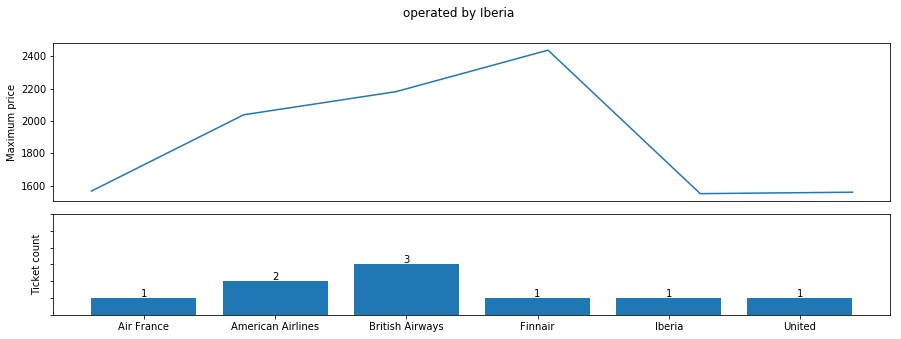

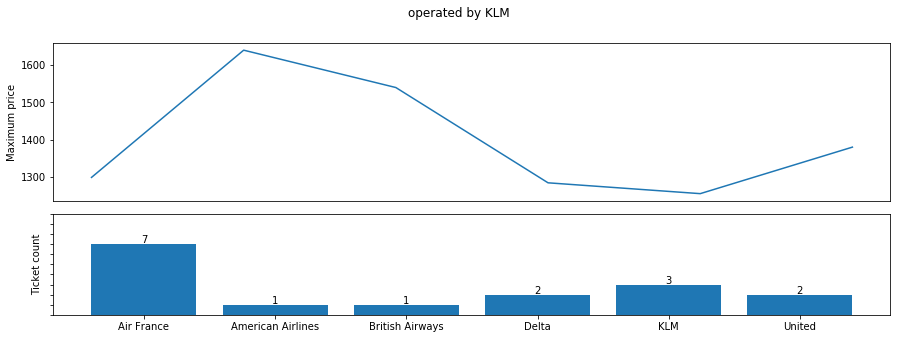

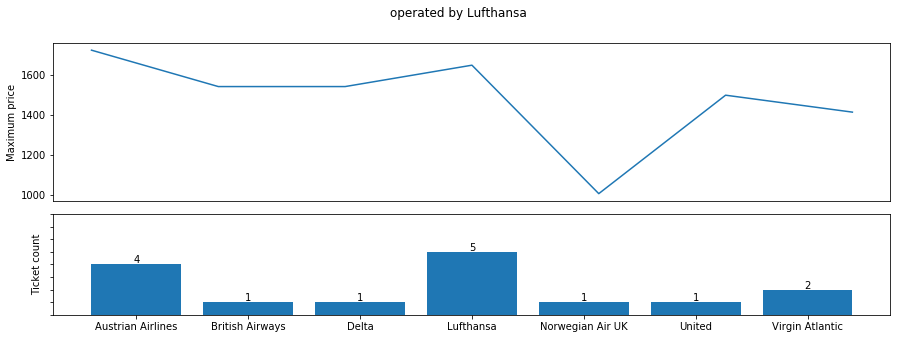

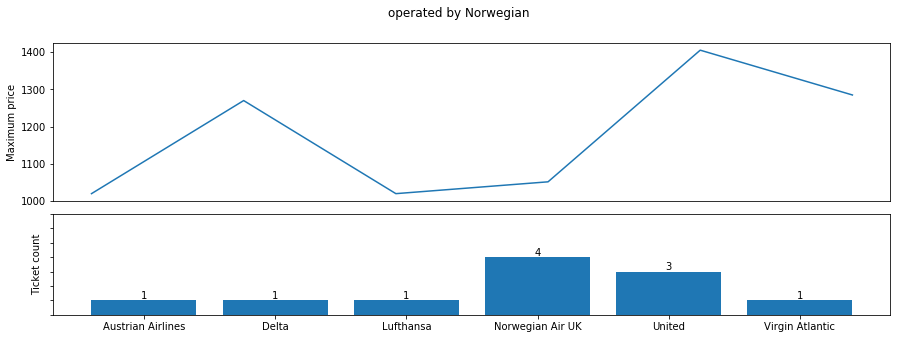

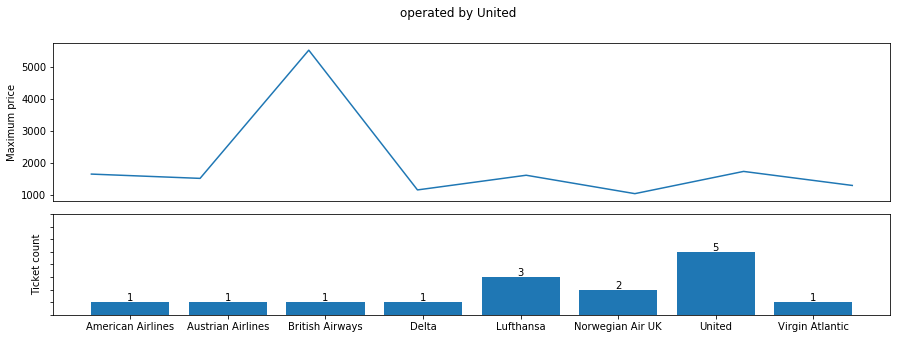

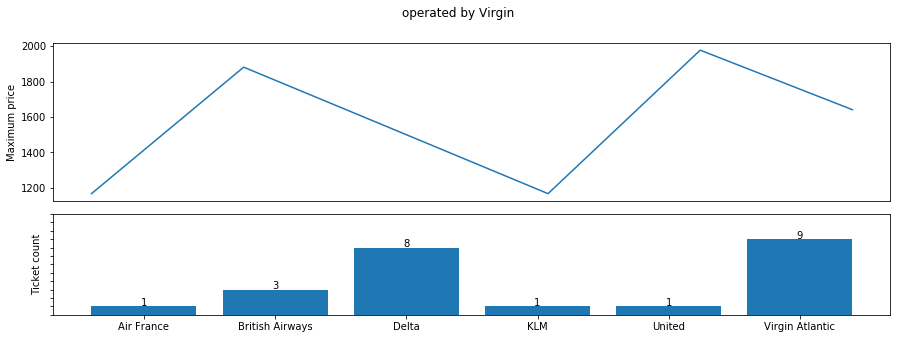

In [133]:
# Data Preparation
airline_operated = data.groupby(["unique_flight", \
                                "airline"]).agg({"price" : [np.min, np.mean, np.max], \
                                                                  "dep_airport": 'first', "departure_datetime": \
                                                 'first', "operated_airline": 'first'}).reset_index()

# Vizualization
for a in np.unique(airline_opeared["operated_airline"]):
    temp = airline_operated[airline_operated["operated_airline"]["first"] == a].groupby("airline").agg({"unique_flight":\
                                                                                                     'count', ("price", "amax"): np.mean})

    # fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 5))
    fig = plt.figure(figsize = (15, 5))
    grid = plt.GridSpec(5, 1, wspace = 0.4, hspace = 0.3)

    plt.subplot(grid[:3, :])
    plt.plot(temp.index, temp[("price", "amax")])  
    plt.xticks([])
    plt.ylabel("Maximum price")

    plt.subplot(grid[3:, :])
    plt.bar(temp.index, temp["unique_flight"])
    for i in range(len(temp[("price", "amax")])):
        plt.annotate(temp[("unique_flight")][i], xy = (temp.index[i], (temp["unique_flight"][i])), \
                    xytext = (temp.index[i], (temp["unique_flight"][i] + 0.1)), ha='center')

    plt.yticks(np.arange(np.max(temp["unique_flight"]) + 4), [])
    plt.ylabel("Ticket count")

    plt.suptitle("operated by %s" %a)
    plt.show()

### Comments

1) When the ticket sold by other airlines for the flight operated by other airline <br>
2) There is often a slight price increase <br>
3) For example, flights operated by American airline (max price from american airline detected is around 1,800 <br>
The price is slightly higher (\$2,000 BA), and other airlines <br>



<br>


<br>

### Future Analysis ideas

1) Scrap the 24 hour data on the weekend and compare the price movement for week day versus weekend <br>
2) Scrap the details about the ticket type (business/ economy etc) as this could impact on the price
